In [1]:
import pickle
import numpy as np
from arrus.utils.imaging import *
import cupy as cp
import matplotlib.pyplot as plt

In [2]:
f = pickle.load(open("offline/7plane_waves.pkl", "rb"))
rf_metadata, rf_data = f["metadata"][-1], np.stack(list(zip(*f["data"]))[-1])

In [3]:
rf_metadata.data_description.custom.keys()

# Data specific for the matrix_array example (NOTE: will be included in the metadata model in the future)
tx_focus = rf_metadata.data_description.custom["matrix_array_tx_focus"]
tx_ang_zx = rf_metadata.data_description.custom["matrix_array_tx_ang_zx"]
tx_ang_zy = rf_metadata.data_description.custom["matrix_array_tx_ang_zy"]

In [4]:
y_grid = np.arange(-8e-3, 8e-3, 0.2e-3)
x_grid = np.arange(-8e-3, 8e-3, 0.2e-3)
z_grid = np.arange(0e-3, 40e-3, 0.2e-3)
sequence = rf_metadata.context.sequence
start_sample, end_sample = sequence.ops[0].rx.sample_range
n_samples = end_sample - start_sample
speed_of_sound = rf_metadata.context.medium.speed_of_sound

pipeline = Pipeline(
    steps=(
        RemapToLogicalOrder(),
        Transpose(axes=(0, 1, 3, 2)),
        Reshape(1, len(sequence.ops), 32, 32, n_samples),
        BandpassFilter(),
        DigitalDownConversion(
            decimation_factor=30,
            fir_order=64
        ),
        ReconstructLri3D(    
            x_grid=x_grid, y_grid=y_grid, z_grid=z_grid,
            tx_foc=tx_focus,
            tx_ang_zx=tx_ang_zx, 
            tx_ang_zy=-tx_ang_zy,
            speed_of_sound=speed_of_sound
        ),
        Squeeze(),
        EnvelopeDetection(),
        LogCompression()
    ),
    placement="/GPU:0"
)

In [5]:
pipeline.prepare(rf_metadata)

deque([<arrus.metadata.ConstMetadata at 0x7f25b299a9b0>])

In [6]:
bmode = pipeline.process(cp.asarray(rf_data))[0].get()

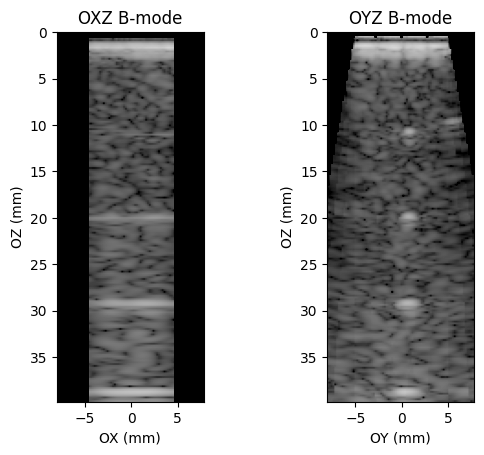

In [7]:
ny, nx, nz = bmode.shape

fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.set_title("OXZ B-mode")
ax0.set_ylabel("OZ (mm)")
ax0.set_xlabel("OX (mm)")
ax0.imshow(bmode[ny//2, :, :].T, cmap="gray", vmin=0, vmax=80, extent=np.asarray([np.min(x_grid), np.max(x_grid), np.max(z_grid), np.min(z_grid)])*1e3)

ax1.set_title("OYZ B-mode")
ax1.set_ylabel("OZ (mm)")
ax1.set_xlabel("OY (mm)")
ax1.imshow(bmode[:, nx//2, :].T, cmap="gray", vmin=0, vmax=80, extent=np.asarray([np.min(y_grid), np.max(y_grid), np.max(z_grid), np.min(z_grid)])*1e3)

# DEBUG

In [8]:
from pathlib import Path


def _get_const_memory_array(module, name, input_array):
    import cupy as cp
    const_arr_ptr = module.get_global(name)
    const_arr = cp.ndarray(shape=input_array.shape, dtype=input_array.dtype,
                           memptr=const_arr_ptr)
    const_arr.set(input_array)
    return const_arr

    
    
class ReconstructLri3Dv2(Operation):
    """
    Rx beamforming for synthetic aperture imaging for matrix array.

    tx_foc, tx_ang_zx, tx_ang_zy: arrays

    Expected input data shape: batch_size, n_emissions, n_rx_x, n_rx_y, n_samples
    :param x_grid: output image grid points (OX coordinates)
    :param y_grid: output image grid points (OY coordinates)
    :param z_grid: output image grid points  (OZ coordinates)
    :param rx_tang_limits: RX apodization angle limits (given as the tangent of the angle), \
      a pair of values (min, max). If not provided or None, [-0.5, 0.5] range will be used
    """

    def __init__(self, x_grid, y_grid, z_grid, tx_foc, tx_ang_zx, tx_ang_zy,
                 speed_of_sound, rx_tang_limits=None):
        self.tx_ang_zy = tx_ang_zy
        self.tx_ang_zx = tx_ang_zx
        self.tx_foc = tx_foc
        self.x_grid = x_grid
        self.y_grid = y_grid
        self.z_grid = z_grid
        self.speed_of_sound = speed_of_sound
        import cupy as cp
        self.num_pkg = cp
        self.rx_tang_limits = rx_tang_limits

    def set_pkgs(self, num_pkg, **kwargs):
        if num_pkg is np:
            raise ValueError("ReconstructLri3D operation is implemented for GPU only.")

    def _get_aperture_boundaries(self, apertures):
        def get_min_max_x_y(ap):
            cords = np.argwhere(ap)
            y, x = zip(*cords)
            return np.min(x), np.max(x), np.min(y), np.max(y)

        min_max_x_y = (get_min_max_x_y(aperture) for aperture in apertures)
        min_x, max_x, min_y, max_y = zip(*min_max_x_y)
        min_x, max_x = np.atleast_1d(min_x), np.atleast_1d(max_x)
        min_y, max_y = np.atleast_1d(min_y), np.atleast_1d(max_y)
        return min_x, max_x, min_y, max_y

    def prepare(self, const_metadata):
        import cupy as cp

        _kernel_source = Path("/home/pjarosik/src/arrus-toolkit/examples/matrix_array/bmode/offline/iq_raw_2_lri_3d.cc").read_text()
        self._kernel_module = self.num_pkg.RawModule(code=_kernel_source)
        self._kernel_module.compile()
        self._kernel = self._kernel_module.get_function("iqRaw2Lri3D")

        # INPUT PARAMETERS.
        # Input data shape.
        self.n_seq, self.n_tx, self.n_rx_y, self.n_rx_x, self.n_samples = const_metadata.input_shape

        seq = const_metadata.context.raw_sequence
        # TODO note: we assume here that a single TX/RX has the below properties
        # the same for each TX/RX. Validation is missing here.
        ref_tx_rx = seq.ops[0]
        ref_tx = ref_tx_rx.tx
        ref_rx = ref_tx_rx.rx
        probe_model = const_metadata.context.device.probe.model
        acq_fs = (const_metadata.context.device.sampling_frequency / ref_rx.downsampling_factor)
        start_sample = ref_rx.sample_range[0]

        self.y_size = len(self.y_grid)
        self.x_size = len(self.x_grid)
        self.z_size = len(self.z_grid)
        output_shape = (self.n_seq, self.n_tx, self.y_size, self.x_size, self.z_size)
        self.output_buffer = self.num_pkg.zeros(output_shape, dtype=self.num_pkg.complex64)
        x_block_size = min(self.z_size, 8)
        y_block_size = min(self.x_size, 8)
        z_block_size = min(self.y_size, 8)
        self.block_size = (x_block_size, y_block_size, z_block_size)
        self.grid_size = (int((self.z_size - 1) // z_block_size + 1),
                          int((self.x_size - 1) // x_block_size + 1),
                          int((self.y_size - 1) // y_block_size + 1))

        self.y_pix = self.num_pkg.asarray(self.y_grid, dtype=self.num_pkg.float32)
        self.x_pix = self.num_pkg.asarray(self.x_grid, dtype=self.num_pkg.float32)
        self.z_pix = self.num_pkg.asarray(self.z_grid, dtype=self.num_pkg.float32)

        # System and transmit properties.
        self.sos = self.num_pkg.float32(self.speed_of_sound)
        self.fs = self.num_pkg.float32(const_metadata.data_description.sampling_frequency)
        self.fn = self.num_pkg.float32(ref_tx.excitation.center_frequency)
        self.tx_foc = self.num_pkg.asarray(self.tx_foc).astype(np.float32)
        self.tx_ang_zx = self.num_pkg.asarray(self.tx_ang_zx).astype(np.float32)
        self.tx_ang_zy = self.num_pkg.asarray(self.tx_ang_zy).astype(np.float32)

        # Probe description
        # TODO specific for Vermon mat-3d probe.
        probe_model = const_metadata.context.device.probe.model
        pitch = probe_model.pitch
        self.n_elements = 32
        n_rows_x = self.n_elements
        n_rows_y = self.n_elements + 3
        # General regular position of elements
        element_pos_x = np.linspace(-(n_rows_x - 1) / 2, (n_rows_x - 1) / 2, num=n_rows_x)
        element_pos_x = element_pos_x * pitch

        element_pos_y = np.linspace(-(n_rows_y - 1) / 2, (n_rows_y - 1) / 2, num=n_rows_y)
        element_pos_y = element_pos_y * pitch
        element_pos_y = np.delete(element_pos_y, (8, 17, 26))

        element_pos_x = element_pos_x.astype(np.float32)
        element_pos_y = element_pos_y.astype(np.float32)
        # Put the data into GPU constant memory.
        device_props = cp.cuda.runtime.getDeviceProperties(0)
        if device_props["totalConstMem"] < 256 * 2 * 4:  # 2 float32 arrays, 256 elements max
            raise ValueError("There is not enough constant memory available!")
        x_elem = np.asarray(element_pos_x, dtype=self.num_pkg.float32)
        self._x_elem_const = _get_const_memory_array(
            self._kernel_module, name="xElemConst", input_array=x_elem)
        y_elem = np.asarray(element_pos_y, dtype=self.num_pkg.float32)
        self._y_elem_const = _get_const_memory_array(
            self._kernel_module, name="yElemConst", input_array=y_elem)

        def get_min_max_x_y(aperture):
            cords = np.argwhere(aperture)
            y, x = zip(*cords)
            return np.min(x), np.max(x), np.min(y), np.max(y)

        # TODO assumption, that probe has the same number elements in both dimensions
        tx_apertures = (tx_rx.tx.aperture.reshape((self.n_elements, self.n_elements)) for tx_rx in seq.ops)
        rx_apertures = (tx_rx.rx.aperture.reshape((self.n_elements, self.n_elements)) for tx_rx in seq.ops)
        tx_bounds = self._get_aperture_boundaries(tx_apertures)
        rx_bounds = self._get_aperture_boundaries(rx_apertures)
        txap_min_x, txap_max_x, txap_min_y, txap_max_y = tx_bounds
        rxap_min_x, rxap_max_x, rxap_min_y, rxap_max_y = rx_bounds
        rxap_size_x = set((rxap_max_x - rxap_min_x).tolist())
        rxap_size_y = set((rxap_max_y - rxap_min_y).tolist())
        if len(rxap_size_x) > 1 or len(rxap_size_y) > 1:
            raise ValueError("Each TX/RX aperture should have the same square aperture size.")
        rxap_size_x = next(iter(rxap_size_x))
        rxap_size_y = next(iter(rxap_size_y))
        # The above can be also compared with the size of data, but right we are not doing it here

        self.tx_ap_first_elem_x = self.num_pkg.asarray(txap_min_x, dtype=self.num_pkg.int32)
        self.tx_ap_last_elem_x = self.num_pkg.asarray(txap_max_x, dtype=self.num_pkg.int32)
        self.tx_ap_first_elem_y = self.num_pkg.asarray(txap_min_y, dtype=self.num_pkg.int32)
        self.tx_ap_last_elem_y = self.num_pkg.asarray(txap_max_y, dtype=self.num_pkg.int32)
        # RX AP
        self.rx_ap_first_elem_x = self.num_pkg.asarray(rxap_min_x, dtype=self.num_pkg.int32)
        self.rx_ap_first_elem_y = self.num_pkg.asarray(rxap_min_y, dtype=self.num_pkg.int32)

        # Find the center of TX aperture.
        # TODO note: this method assumes that all TX/RXs have a rectangle TX aperture
        # 1. Find the position of the center.
        tx_ap_center_x = (element_pos_x[txap_min_x] + element_pos_x[txap_max_x]) / 2
        tx_ap_center_y = (element_pos_y[txap_min_y] + element_pos_y[txap_max_y]) / 2
        # element index -> element position
        ap_center_elem_x = np.interp(tx_ap_center_x, element_pos_x, np.arange(len(element_pos_x)))
        ap_center_elem_y = np.interp(tx_ap_center_y, element_pos_y, np.arange(len(element_pos_y)))
        # TODO Currently 'floor' NN, consider interpolating into
        #  the center delay
        ap_center_elem_x = np.floor(ap_center_elem_x).astype(np.int32)
        ap_center_elem_y = np.floor(ap_center_elem_y).astype(np.int32)
        self.tx_ap_cent_x = self.num_pkg.asarray(tx_ap_center_x).astype(np.float32)
        self.tx_ap_cent_y = self.num_pkg.asarray(tx_ap_center_y).astype(np.float32)

        # FIND THE TX_CENTER_DELAY
        # Make sure, that for all TX/RXs:
        # The center element is in the aperture
        # All TX/RX have (almost) the same delay in the aperture's center
        tx_center_delay = None
        for i, tx_rx in enumerate(seq.ops):
            tx = tx_rx.tx
            tx_center_x = ap_center_elem_x[i]
            tx_center_y = ap_center_elem_y[i]
            aperture = tx.aperture.reshape((self.n_elements, self.n_elements))
            delays = np.zeros(aperture.shape)
            delays[:] = np.nan
            delays[np.where(aperture)] = tx.delays.flatten()
            if not aperture[tx_center_y, tx_center_x]:
                # The aperture's center should transmit signal
                raise ValueError("TX aperture center should be turned on.")
            if tx_center_delay is None:
                tx_center_delay = delays[tx_center_y, tx_center_x]
            else:
                # Make sure that the center' delays is the same position for all TX/RXs
                current_center_delay = delays[tx_center_y, tx_center_x]
                if not np.isclose(tx_center_delay, current_center_delay):
                    raise ValueError(f"TX/RX {i}: center delay is not close "
                                     f"to the center delay of other TX/RXs."
                                     f"Assumed that the center element is:"
                                     f"({tx_center_y, tx_center_x}). "
                                     f"Center delays should be equalized "
                                     f"for all TX/RXs. ")

        # MIN/MAX TANG
        if self.rx_tang_limits is not None:
            self.min_tang, self.max_tang = self.rx_tang_limits
        else:
            # Default:
            self.min_tang, self.max_tang = -0.5, 0.5
        self.min_tang = self.num_pkg.float32(self.min_tang)
        self.max_tang = self.num_pkg.float32(self.max_tang)
        burst_factor = ref_tx.excitation.n_periods / (2 * self.fn)
        self.initial_delay = -start_sample / 65e6 + burst_factor + tx_center_delay
        self.initial_delay = self.num_pkg.float32(self.initial_delay)
        self.rx_apod = scipy.signal.windows.hamming(20).astype(np.float32)
        self.rx_apod = self.num_pkg.asarray(self.rx_apod)
        self.n_rx_apod = self.num_pkg.int32(len(self.rx_apod))

        return const_metadata.copy(input_shape=output_shape)

    def process(self, data):
        data = self.num_pkg.ascontiguousarray(data)
        params = (
            self.output_buffer, data,
            self.n_seq, self.n_tx, self.n_rx_y, self.n_rx_x, self.n_samples,
            self.z_pix, self.z_size,
            self.x_pix, self.x_size,
            self.y_pix, self.y_size,
            self.sos, self.fs, self.fn,
            self.tx_foc, self.tx_ang_zx, self.tx_ang_zy,
            self.tx_ap_cent_x, self.tx_ap_cent_y,
            self.tx_ap_first_elem_x, self.tx_ap_last_elem_x,
            self.tx_ap_first_elem_y, self.tx_ap_last_elem_y,
            self.min_tang, self.max_tang,
            self.min_tang, self.max_tang,
            self.initial_delay,
            self.rx_apod, self.n_rx_apod,
            self.rx_ap_first_elem_x, self.rx_ap_first_elem_y
        )
        self._kernel(self.grid_size, self.block_size, params)
        return self.output_buffer


y_grid = np.arange(-8e-3, 8e-3, 0.2e-3)
x_grid = np.arange(-8e-3, 8e-3, 0.2e-3)
z_grid = np.arange(0e-3, 40e-3, 0.2e-3)
sequence = rf_metadata.context.sequence
start_sample, end_sample = sequence.ops[0].rx.sample_range
n_samples = end_sample - start_sample
speed_of_sound = rf_metadata.context.medium.speed_of_sound

pipeline = Pipeline(
    steps=(
        RemapToLogicalOrder(),
        Transpose(axes=(0, 1, 3, 2)),
        Reshape(1, len(sequence.ops), 32, 32, n_samples),
        BandpassFilter(),
        DigitalDownConversion(
            decimation_factor=30,
            fir_order=64,
            
        ),
        ReconstructLri3Dv2(    
            x_grid=x_grid, y_grid=y_grid, z_grid=z_grid,
            tx_foc=tx_focus,
            tx_ang_zx=tx_ang_zx, 
            tx_ang_zy=tx_ang_zy,
            speed_of_sound=speed_of_sound
        ),
        Squeeze(),
    ),
    placement="/GPU:0"
)

pipeline.prepare(rf_metadata)
lris = pipeline.process(cp.asarray(rf_data))[0].get()

/tmp/ipykernel_16392/1723533910.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(20*np.log10(np.abs(lris[6, :, ny//2, :])).T, cmap="gray", vmin=0, vmax=80)


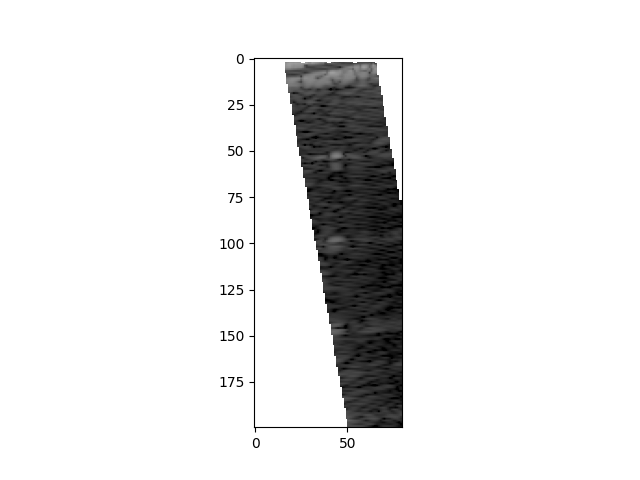

In [9]:
%matplotlib widget
plt.figure()
plt.imshow(20*np.log10(np.abs(lris[6, :, ny//2, :])).T, cmap="gray", vmin=0, vmax=80)

/tmp/ipykernel_16392/2117348348.py:3: RuntimeWarning: divide by zero encountered in log10
  img = 20*np.log10(np.abs(hri[:, ny//2, :]))


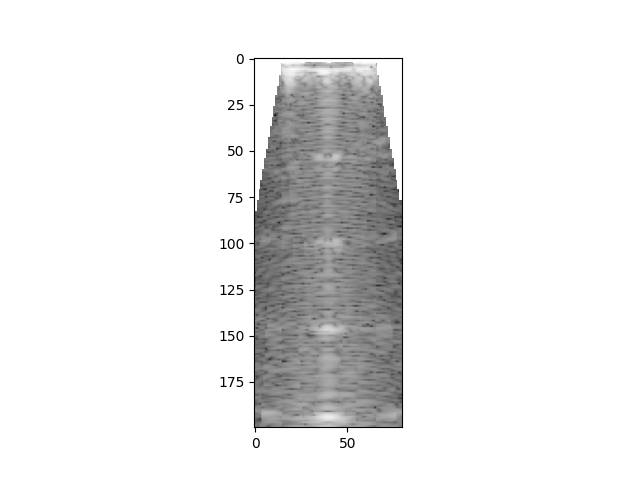

In [10]:
hri = np.nanmean(lris, axis=0)
plt.figure()
img = 20*np.log10(np.abs(hri[:, ny//2, :]))
plt.imshow(img.T, cmap="gray")

In [11]:
hri = np.mean(np.abs(lris), axis=0)
img = 20*np.log10(hri[:, ny//2, :])
plt.imshow(img.T, cmap="gray")

/tmp/ipykernel_16392/3442633548.py:2: RuntimeWarning: divide by zero encountered in log10
  img = 20*np.log10(hri[:, ny//2, :])
